In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__) 

2.7.0


In [ ]:

import sys
import os
import json
import pandas as pd
import numpy as np
import optparse
import tensorflow
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
#from tensorflow.keras.layers.Embedding import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import OrderedDict

In [ ]:
# Run this cell only if you are using Colab with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
cwd = os.getcwd()
dataset_dir = os.path.join(cwd,"drive","MyDrive", 'Akim_thesis/dataset')
print(dataset_dir)

/content/drive/MyDrive/Akim_thesis/dataset


In [ ]:
dataset = pd.read_csv (r''+dataset_dir+'/test.csv')
dataset.head()

,Date,Time,PID,Level,Label,MessageSum,ModuleSum,RequestSum
0,2021-07-05,14:01:15.456,918,ERROR,cinder,4.136373,1.412674,0.0
1,2021-07-05,14:01:25.461,918,ERROR,cinder,4.136373,1.412674,0.0
2,2021-07-05,14:01:35.468,918,ERROR,cinder,4.136373,1.412674,0.0
3,2021-07-05,14:01:45.471,918,ERROR,cinder,4.136373,1.412674,0.0
4,2021-07-05,14:01:55.477,918,ERROR,cinder,4.136373,1.412674,0.0


In [ ]:
def nameToOut(_name):
    if _name == 'INFO' or _name == 'DEBUG':
        return 0
    else:
        return 1

In [ ]:
dataset['Output'] = [nameToOut(item) for item in  dataset['Level']]
dataset.head()

,Date,Time,PID,Level,Label,MessageSum,ModuleSum,RequestSum,Output
0,2021-07-05,14:01:15.456,918,ERROR,cinder,4.136373,1.412674,0.0,1
1,2021-07-05,14:01:25.461,918,ERROR,cinder,4.136373,1.412674,0.0,1
2,2021-07-05,14:01:35.468,918,ERROR,cinder,4.136373,1.412674,0.0,1
3,2021-07-05,14:01:45.471,918,ERROR,cinder,4.136373,1.412674,0.0,1
4,2021-07-05,14:01:55.477,918,ERROR,cinder,4.136373,1.412674,0.0,1


In [ ]:
print(dataset.loc[dataset['Output']==1])

             Date          Time   PID  ... ModuleSum RequestSum  Output
0      2021-07-05  14:01:15.456   918  ...  1.412674   0.000000       1
1      2021-07-05  14:01:25.461   918  ...  1.412674   0.000000       1
2      2021-07-05  14:01:35.468   918  ...  1.412674   0.000000       1
3      2021-07-05  14:01:45.471   918  ...  1.412674   0.000000       1
4      2021-07-05  14:01:55.477   918  ...  1.412674   0.000000       1
...           ...           ...   ...  ...       ...        ...     ...
34985  2021-07-16  17:39:25.665  2560  ...  1.711737   2.236068       1
35125  2021-07-16  17:43:28.703  2560  ...  1.711737   2.236068       1
35128  2021-07-16  17:43:28.713  2560  ...  1.944311   2.236068       1
35130  2021-07-16  17:43:28.714  2560  ...  1.725066   2.236068       1
35994  2021-07-16  18:07:53.678  2560  ...  1.711737   2.236068       1

[17826 rows x 9 columns]


In [ ]:
dataset_error = (dataset.loc[dataset['Output']==1]).copy()

In [ ]:
import calendar
import time
def timeToLong(_time):
    return calendar.timegm(time.strptime(_time, '%Y-%m-%dT%H:%M:%S.%fZ'))

In [ ]:
dataset1 = [str(item2).strip()+'Z' for item2 in dataset_error['Time']]
dataset2 = [str(item).strip()+'T' for item in dataset_error['Date']]
dataset_error['Timestamp'] = pd.DataFrame(dataset2) + pd.DataFrame(dataset1)


In [ ]:
dataset_error['Timestamp'] = [timeToLong(item) for item in dataset_error['Timestamp']]
print(dataset_error)

In [ ]:
dataset_error = dataset_error.drop(['Date','Time'], axis=1)

In [ ]:
dataset_error = dataset_error.drop(['Timestamp'], axis=1)

In [ ]:
def nameToOutError(_name):
    if _name == 'WARNING':
        return 0
    else:
        return 1

In [ ]:
dataset_error['Output2'] = [nameToOutError(item) for item in  dataset_error['Level']]

In [ ]:
dataset_error = dataset_error.drop(['Output','Level'], axis=1)

In [ ]:
dataset_error['Output'] = dataset_error['Output2']

In [ ]:
dataset_error = dataset_error.drop(['Output2'], axis=1)

In [ ]:
dataset_error = dataset_error.drop(['PID'], axis=1)

In [ ]:
Y = dataset_error['Output']
X = dataset_error.drop(['Output','Label'], axis=1)
#X = X.drop(['Date','Time'], axis=1)

In [ ]:
from sklearn import preprocessing
names=["PID","MessageSum","RequestSum", "ModuleSum"]

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(X_scaled,columns = names)

In [ ]:
Y = pd.DataFrame(Y)
X = X.join(Y['Output'])
Errors = X.loc[X['Output']==0]
Errors.head()
Errors.loc[Errors['ModuleSum']!=0]
Errors.shape

(2501, 4)

In [ ]:
SEED = 1234
Errors = Errors.sample(30000,random_state=SEED,replace=True)
Normal = X.loc[X['Output']==1]
data = [Normal, Errors]
data = pd.concat(data)

In [ ]:
#y = data['Output']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1, stratify=Y)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify=y_train)

In [ ]:
y_train = X_train['Output']
y_valid = X_valid['Output']
y_test = X_test['Output']

In [ ]:
X_test = X
y_test = Y

In [ ]:
X_test = X_test.drop('Output', axis = 1)

In [ ]:
X_valid = X_valid.drop(['Output'],axis=1)
X_train = X_train.drop(['Output'],axis=1)
X_test = X_test.drop(['Output'],axis=1)

In [ ]:
X_train = X_train.to_numpy() #.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.to_numpy() #.reshape((X_valid.shape[0], 1, X_valid.shape[1]))


In [ ]:
y_train =y_train.to_numpy()

In [ ]:
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])


In [ ]:
X_valid = X_valid.reshape(X_valid.shape[0],1,X_valid.shape[1])

## **SVM TRAINING**

In [ ]:
example_id = np.array(['%d' % i for i in range(len(y_train))])

In [ ]:
import tensorflow as tf

x_column_name = 'x'
example_id_column_name = 'example_id'

train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    x={x_column_name: X_train, example_id_column_name: example_id},
    y=y_train,
    num_epochs=None,
    shuffle=True)

svm = tf.contrib.learn.SVM(
    example_id_column=example_id_column_name,
    feature_columns=(tf.contrib.layers.real_valued_column(
        column_name=x_column_name, dimension=3),),
    l2_regularization=0.1,
    model_dir='/content/drive/MyDrive/Akim_thesis/model_SVM_L1/')

#svm.fit(input_fn=train_input_fn, steps=10000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f00556c8250>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/content/drive/MyDrive/Akim_thesis/model_SVM_L1/', '_session_creation_timeout_secs': 7200}


In [ ]:
#X_test = X_test.to_numpy()
#y_test = y_test.to_numpy()
example_id2 = np.array(['%d' % i for i in range(len(y_test))])
x_column_name = 'x' 
example_id_column_name = 'example_id'

test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    x={x_column_name: X_test, example_id_column_name: example_id2},
    y=y_test,
    num_epochs=None,
    batch_size=17826,
    shuffle=False)

In [ ]:
score = svm.evaluate(input_fn=test_input_fn, steps=1)

In [ ]:
y_prediction = svm.predict_classes(input_fn=test_input_fn, as_iterable=False)

INFO:tensorflow:Created variable linear/bias_weight:0, with device=
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Akim_thesis/model_SVM_L22/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


**End SVM training**

# **Model definition ANN / FNN**

In [ ]:
    model = Sequential()
    #model.add(Dense(128, activation='relu', input_shape=(3,)))

    model.add(LSTM(128, input_shape=(1,3), recurrent_dropout=0.5))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

MODEL FNN

In [ ]:
# Initialize the constructor
model = Sequential()
# Add an input layer 
model.add(Dense(128, activation='relu', input_shape=(4,)))
#model.add(Dense(20, activation='relu'))
# Add one hidden layer 
#model.add(Dropout(0.6))
#model.add(Dense(10, activation='relu'))
# Add an output layer 
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Optimization params
# -------------------
import tensorflow as tf
# Loss
loss = tf.keras.losses.binary_crossentropy

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Akim_thesis/tb_logs_lstm_l2_sans

In [ ]:
import os
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/Akim_thesis/', 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'LSTM_L2_SANS'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True,
                                                    save_best_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join("/content/drive/My Drive/Akim_thesis/", 'tb_logs_lstm_l2_sans')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    callbacks.append(es_callback)

In [ ]:
model.fit(x=X_train,
          y=y_train,
          epochs=300,
          validation_data=(X_valid,y_valid),
          batch_size=128,
          callbacks=callbacks)

Epoch 1/300
293/293 [==============================] - 9s 15ms/step - loss: 0.1672 - accuracy: 0.9384 - val_loss: 0.0166 - val_accuracy: 0.9981
Epoch 2/300
293/293 [==============================] - 4s 14ms/step - loss: 0.0144 - accuracy: 0.9978 - val_loss: 0.0117 - val_accuracy: 0.9981
Epoch 3/300
293/293 [==============================] - 4s 14ms/step - loss: 0.0129 - accuracy: 0.9978 - val_loss: 0.0113 - val_accuracy: 0.9981
Epoch 4/300
293/293 [==============================] - 4s 14ms/step - loss: 0.0122 - accuracy: 0.9978 - val_loss: 0.0110 - val_accuracy: 0.9981
Epoch 5/300
293/293 [==============================] - 4s 14ms/step - loss: 0.0120 - accuracy: 0.9978 - val_loss: 0.0108 - val_accuracy: 0.9981
Epoch 6/300
293/293 [==============================] - 4s 14ms/step - loss: 0.0112 - accuracy: 0.9979 - val_loss: 0.0105 - val_accuracy: 0.9981
Epoch 7/300
293/293 [==============================] - 4s 14ms/step - loss: 0.0108 - accuracy: 0.9979 - val_loss: 0.0104 - val_accuracy:

In [ ]:
model_path = os.path.join("", "/content/drive/MyDrive/Akim_thesis/classification_experiments/LSTM_L2_Oct18_20-48-46/ckpts/cp_25.ckpt")

model.load_weights(model_path)

In [ ]:
model.save("/content/drive/MyDrive/Akim_thesis/classification_experiments/LSTM_L2_Oct18_20-48-46/ckpts/model_fnn.h5")

In [ ]:
with open('/content/drive/MyDrive/Akim_thesis/classification_experiments/LSTM_L2_Oct18_20-48-46/ckpts/model_fnn.json', 'w') as outfile:
        outfile.write(model.to_json())

1722

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Akim_thesis/classification_experiments/LSTM_P_Sep28_23-41-55/ckpts/model_lstm.h5")

In [ ]:
X_test = X_test.to_numpy()
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)


558/558 [==============================] - 2s 3ms/step - loss: 0.0016 - accuracy: 0.9998


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn import preprocessing

#Y_prediction = model.predict(X_test)
# Convert predictions classes to one hot vectors 
#Y_pred_classes = np.argmax(Y_prediction,axis = 1) 

In [ ]:
print(Y_prediction)

[[0.9957775 ]
 [0.9957775 ]
 [0.9957775 ]
 ...
 [0.999853  ]
 [0.83037686]
 [0.999962  ]]


In [ ]:
def probToClass(prob):
  if prob>0.5:
    return 1
  else:
    return 0

In [ ]:
Y_prediction = [probToClass(item) for item in Y_prediction]

In [ ]:
print(Y_prediction)

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 

In [ ]:
confusion_mtx = confusion_matrix(y_test,y_prediction)
class_report = classification_report(y_test, y_prediction, 
                                     target_names=["Warning","Error"])  # target_names must be ordered depending on the class labels
print('Confusion Matrix:')
print(confusion_mtx)
print()
print('Classification Report:')
print(class_report)

Confusion Matrix:
[[ 2499     2]
 [   21 15304]]

Classification Report:
              precision    recall  f1-score   support

     Warning       0.99      1.00      1.00      2501
       Error       1.00      1.00      1.00     15325

    accuracy                           1.00     17826
   macro avg       1.00      1.00      1.00     17826
weighted avg       1.00      1.00      1.00     17826



In [ ]:
!pip install Scikit-plot

<Figure size 720x504 with 0 Axes>

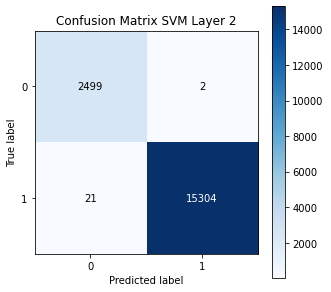

<Figure size 720x504 with 0 Axes>

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skplt
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_prediction, figsize = (5, 5), title= 'Confusion Matrix SVM Layer 2' )
plt.figure(figsize = (10,7))